In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
from numpy import linalg as nplin

ModuleNotFoundError: No module named 'numpy'

Solving ill-condition problems can result in weird solutions

In [40]:
data = np.loadtxt( "salary.txt" )
X = np.c_[ data[:,:-1], np.ones( data.shape[0] ) ]
y = data[:,-1]

NameError: name 'np' is not defined

In [41]:
w = nplin.inv( (X.T).dot( X ) ).dot( (X.T).dot( y ) )
print( "Train MAE is ", np.average( np.abs( X.dot( w ) - y ) ) )
print( w )

NameError: name 'nplin' is not defined

Using regularization, say L2 regularization, helps stabilize the solution

In [42]:
w = nplin.inv( (X.T).dot( X ) + 1e-4 * np.eye( X.shape[1] ) ).dot( (X.T).dot( y ) )
print( "Train MAE is ", np.average( np.abs( X.dot( w ) - y ) ) )
print( w )

NameError: name 'nplin' is not defined

**Careful**: Over regularization can distort the problem and give bad solutions itself. Note that the coordinates of the model vector shrink with over regularization.

In [ ]:
w = nplin.inv( (X.T).dot( X ) + 1e4 * np.eye( X.shape[1] ) ).dot( (X.T).dot( y ) )
print( "Train MAE is ", np.average( np.abs( X.dot( w ) - y ) ) )
print( w )

Train MAE is  21838.09821096856
[768.17659961   1.55590391   5.54306853   8.37962684   4.17568911
   9.66998249   8.62553833   1.35876757  19.65428839]


In [ ]:
from cs771 import plotData as pd
from cs771 import optLib as opt
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import random

**Loading Benchmark Datasets using _sklearn_**: the _sklearn_ library, along with providing methods for various ML problems like classification, regression and clustering, also gives the facility to download various datasets. We will use the _California Housing_ dataset that requires us to predict house prices in the city of California using 8 features such as median income, number of rooms, age of the house, etc. Check this [[link]](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) to learn more.

**Caution**: when executing the dataset download statement for the first time, sklearn will attempt to download this dataset from an internet source. Make sure you have a working internet connection at this point otherwise the statement will fail. Once you have downloaded the dataset once, it will be cached and you would not have to download it again and again.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
X = housing.data
y = housing.target
(n, d) = X.shape
print( "This dataset has %d data points and %d features" % (n,d) )
print( "The mean value of the (real-valued) labels is %.2f" % np.mean(y) )

X_trn, X_tst, y_trn, y_tst = train_test_split( X, y, train_size = 1000 )
print( "The training dataset has %d data points and %d features" % X_trn.shape )
print( "The mean value of the training labels is %.2f" % np.mean(y_trn) )

This dataset has 20640 data points and 8 features
The mean value of the (real-valued) labels is 2.07
The training dataset has 1000 data points and 8 features
The mean value of the training labels is 2.06


**Experiments with Ridge Regression**: we first use ridge regression (that uses the least squares loss and $L_2$ regularization) to try and solve this problem. We will try out a variety of regularization parameters ranging across 15 orders of magnitude from $10^{-4}$ all the way to $10^{11}$. Note that as the regularization parameter increases, the model norm drops significantly so that at extremely high levels of regularization, the learnt model is almost a zero vector. Naturally, such a trivial model offers poor prediction hence, beyond a point, increasing the regularization parameter decreases prediction performance. We measure prediction performance in term of _mean absolute error_ (shortened to MAE).

**Regularization Path**: the concept of a regularization path traces the values different coordinates of the model take when the problem is solved using various values of the regularization parameter. Note that initially, when there is very feeble regularization (say $\alpha = 10^{-4}$), model coordinates take large magnitude values, some positive, others negative. However, as regularization increases, all model coordinate values _shrink_ towards zero.

The best test MAE I got was  0.5426013359502445


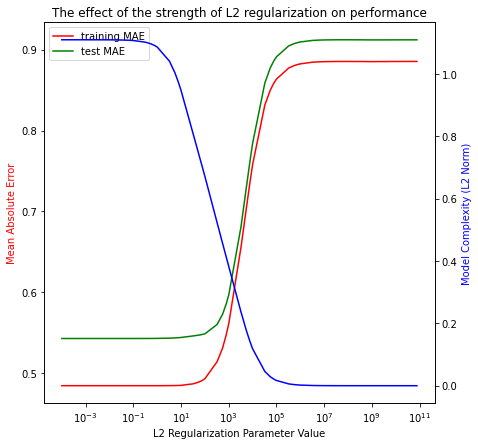

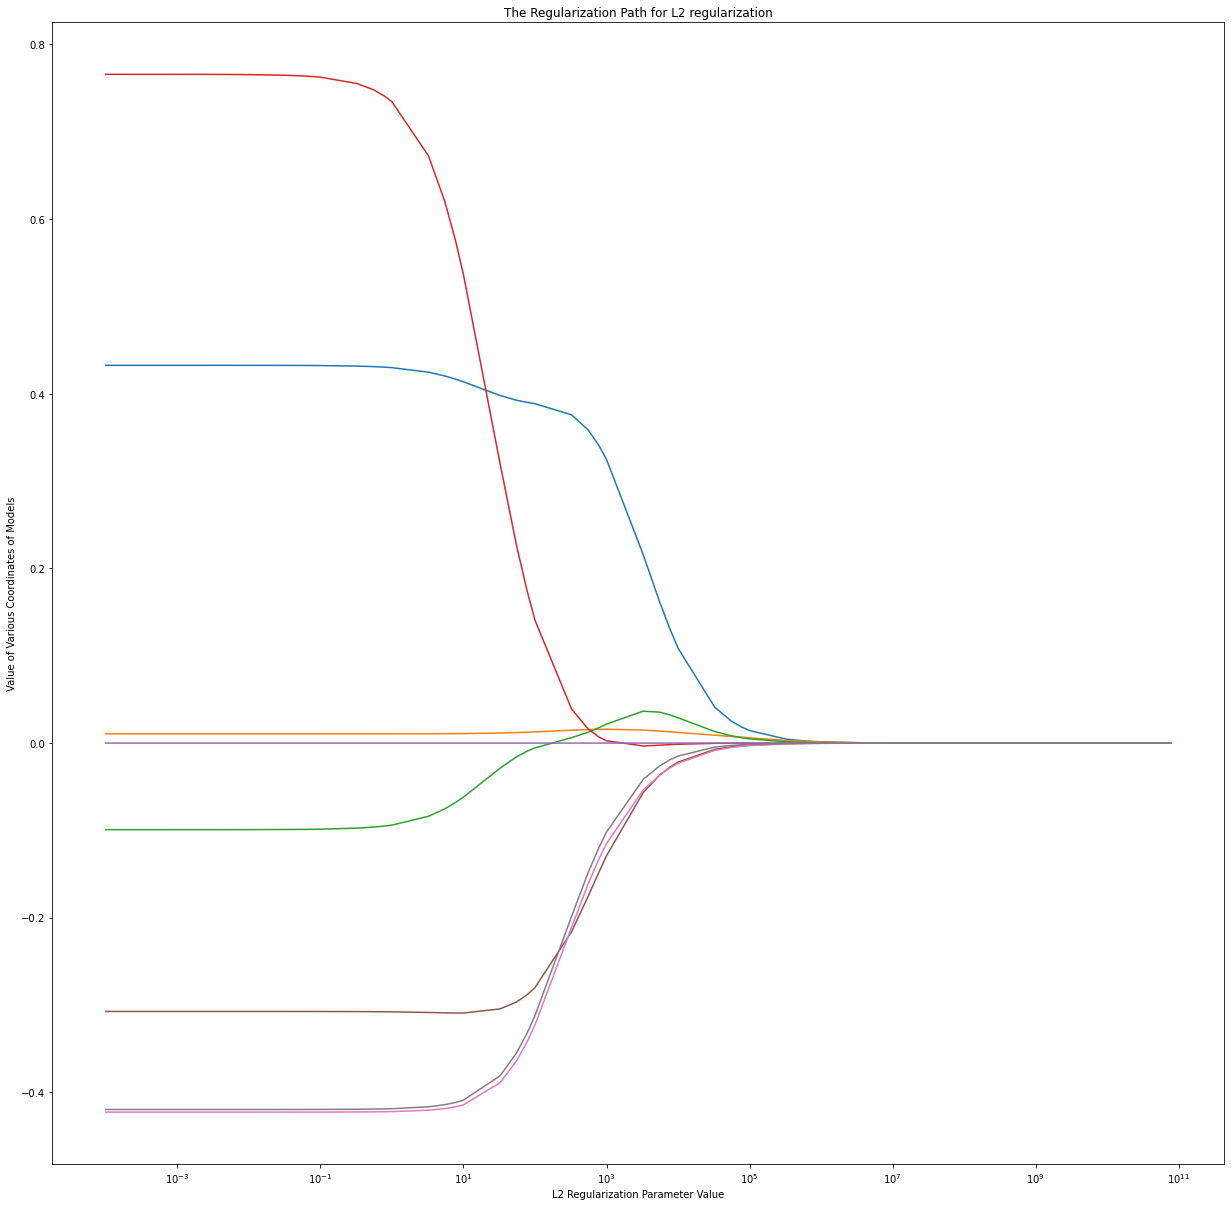

In [ ]:
(n, d) = X.shape

alphaVals = np.concatenate( [np.linspace( 1e-4 * 10**i, 1e-4 * 10**(i+1), num = 5 )[:-1] for i in range(15)] )
MAEVals_trn = np.zeros_like( alphaVals )
MAEVals_tst = np.zeros_like( alphaVals )
modelNorms = np.zeros_like( alphaVals )
models = np.zeros( (X_trn.shape[1], len(alphaVals)) )
biases = np.zeros_like( alphaVals )

for i in range( len(alphaVals) ):
    reg = linear_model.Ridge( alpha = alphaVals[i], fit_intercept = True )
    reg.fit( X_trn, y_trn )
    w = reg.coef_
    b = reg.intercept_
    # Record what test MAE we got to track progress
    # Careful -- test data must never be used to guide training
    # We are never going to use these MAE values to train
    MAEVals_trn[i] = np.mean( np.abs( X_trn.dot(w) + b - y_trn ) )
    MAEVals_tst[i] = np.mean( np.abs( X_tst.dot(w) + b - y_tst ) )
    modelNorms[i] = nplin.norm( w, 2 )
    models[:,i] = w
    biases[i] = b

bestRRMAE = min( MAEVals_tst )
print( "The best test MAE I got was ", bestRRMAE )

fig = pd.getFigure( 7, 7 )
ax = plt.gca()
ax.set_title( "The effect of the strength of L2 regularization on performance" )
ax.set_xlabel( "L2 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals_trn, color = 'r', linestyle = '-', label = "training MAE" )
ax.semilogx( alphaVals, MAEVals_tst, color = 'g', linestyle = '-', label = "test MAE" )
ax2 = ax.twinx()
ax2.set_ylabel( "Model Complexity (L2 Norm)", color = "b" )
ax2.semilogx( alphaVals, modelNorms, color = 'b', linestyle = '-' )
ax.legend()

fig2 = pd.getFigure( 21, 21 )
plt.figure( fig2.number )
plt.title( "The Regularization Path for L2 regularization" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(d):
    plt.semilogx( alphaVals, models[i,:] )

Notice what happens to the biases as regularization is increased. They approach the average value of the labels. Can you guess why is this the case?

[-34.44298066 -34.44295786 -34.44293507 -34.44291227 -34.44288947
 -34.4426615  -34.44243352 -34.44220552 -34.4419775  -34.43969653
 -34.43741408 -34.43513016 -34.43284478 -34.40991157 -34.3868382
 -34.36363037 -34.34029352 -34.10089388 -33.85330796 -33.60057087
 -33.34484832 -30.83254308 -28.59317598 -26.64816171 -24.95630965
 -15.4927451  -11.39644347  -9.05229528  -7.50324119  -2.3192536
  -0.88355349  -0.18299502   0.234477     1.35030073   1.58724004
   1.69805469   1.7652201    1.97009597   2.02285208   2.04793121
   2.06266621   2.10101412   2.1084785    2.1116077    2.11329748
   2.11659881   2.11640703   2.11579087   2.11505852   2.10785299
   2.10228716   2.09798016   2.09455757   2.07945269   2.0745298
   2.07208939   2.07063184   2.06676945   2.06600121   2.0656724 ]


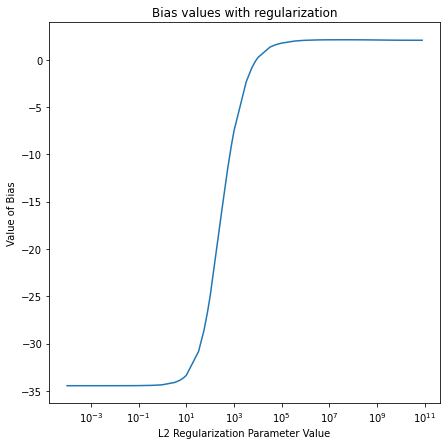

In [ ]:
print( biases )
fig3 = pd.getFigure( 7, 7 )
plt.figure( fig3.number )
plt.title( "Bias values with regularization" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Bias" )
plt.semilogx( alphaVals, biases )

Some of the features can be thrown away without affecting performance too much.

**Warning**: assignment in Python does not always create a copy. Be careful!

In [ ]:
w = np.copy( models[ :, 0 ] )
b = biases[ 0 ]
print( np.mean( np.abs( X_tst.dot(w) + b - y_tst ) ) )
w[ np.abs( w ) < 5*1e-2 ] = 0
print( np.mean( np.abs( X_tst.dot(w) + b - y_tst ) ) )
w

0.5426013359502445
0.5832309150732378


array([ 0.43257661,  0.        , -0.09914162,  0.76577947,  0.        ,
       -0.30731454, -0.42258154, -0.41959179])

**Spurious Features present a Sparse Recovery Problem**: in this experiment we add 1000 new features to the dataset (with the new features containing nothing but pure random white noise), taking the total number of features to 1008 which is greater than the total number of data points which is 1000. Upon executing ridge regression on this dataset, we find something very surprising. We find that at low levels of regularization, the method offers almost zero train MAE!

The above may seem paradoxical since the new features were white noise and had nothing informative to say about the problem. What happened was that these new features increased the power of the linear model and since there was not enough data, ridge regression used these new features to artificially reduce the error. This is clear from the regularization path plot.

Such a model is actually not very useful since it would not perform very well on test data. To do well on test data, the only way is to identify the truly informative features (of which there are only 8 or less). Note that in the error plot, the blue curve demonstrates the amount of weight the model puts on the spurious features. Only when there is heavy regularization (around $\alpha = 10^4$ does the model stop placing large weights on the spurious features and error levels climb to around 0.53, where they were when spurious features were not present. Thus, L2 regularization may not be the best option when there are several irrelevant features.

In [ ]:
( n_trn, d ) = X_trn.shape
X_spurious = np.random.normal( 0, 1, (n, 1000) )
X_trn_extend = np.hstack( ( X_trn, X_spurious[ :n_trn, : ] ) )
X_tst_extend = np.hstack( ( X_tst, X_spurious[ n_trn:, : ] ) )
( n_trn, d ) = X_trn_extend.shape

MAEVals_trn = np.zeros_like( alphaVals )
MAEVals_tst = np.zeros_like( alphaVals )
spuriousModelNorms = np.zeros_like( alphaVals )
models = np.zeros( (d, len(alphaVals)) )

for i in range( len(alphaVals) ):
    reg = linear_model.Ridge( alpha = alphaVals[i] )
    reg.fit( X_trn_extend, y_trn )
    w = reg.coef_
    b = reg.intercept_
    MAEVals_trn[i] = np.mean( np.abs( X_trn_extend.dot(w) + b - y_trn ) )
    MAEVals_tst[i] = np.mean( np.abs( X_tst_extend.dot(w) + b - y_tst ) )
    spuriousModelNorms[i] = nplin.norm( w[8:], 2 )
    models[:,i] = w

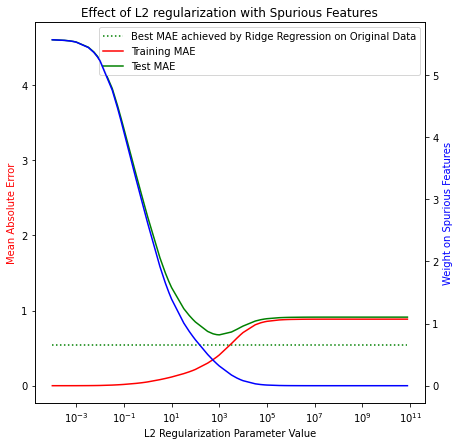

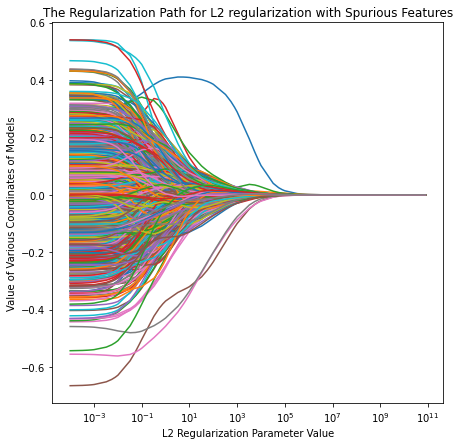

In [ ]:
fig5 = pd.getFigure( 7, 7 )
plt.plot( alphaVals, bestRRMAE * np.ones_like(alphaVals), color = 'g', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Original Data" )
plt.legend()
ax = plt.gca()
ax.set_title( "Effect of L2 regularization with Spurious Features" )
ax.set_xlabel( "L2 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals_trn, color = 'r', linestyle = '-', label = "Training MAE" )
ax.semilogx( alphaVals, MAEVals_tst, color = 'g', linestyle = '-', label = "Test MAE" )
ax.legend()
ax2 = ax.twinx()
ax2.set_ylabel( "Weight on Spurious Features", color = "b" )
ax2.semilogx( alphaVals, spuriousModelNorms, color = 'b', linestyle = '-' )

fig6 = pd.getFigure( 7, 7 )
plt.figure( fig6.number )
plt.title( "The Regularization Path for L2 regularization with Spurious Features" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(d):
    plt.semilogx( alphaVals, models[i,:] )

**LASSO for Sparse Recovery**: the LASSO (Least Absolute Shrinkage and Selection Operator) performs regression using the least squares loss and the $L_1$ regularizer instead. The error plot and the regularization path plots show that LASSO offers a far quicker identification of the spurious features. LASSO is indeed a very popular technique to deal with sparse recovery when we have very less data and suspect that there may be irrelevant features.

In [ ]:
MAEVals_trn = np.zeros_like( alphaVals )
MAEVals_tst = np.zeros_like( alphaVals )
spuriousModelNorms = np.zeros_like( alphaVals )
models = np.zeros( (X_trn_extend.shape[1], len(alphaVals)) )

for i in range( len(alphaVals) ):
    reg = linear_model.Lasso( alpha = alphaVals[i] )
    reg.fit( X_trn_extend, y_trn )
    w = reg.coef_
    b = reg.intercept_
    MAEVals_trn[i] = np.mean( np.abs( X_trn_extend.dot(w) + b - y_trn ) )
    MAEVals_tst[i] = np.mean( np.abs( X_tst_extend.dot(w) + b - y_tst ) )
    spuriousModelNorms[i] = nplin.norm( w[8:], 2 )
    models[:,i] = w

C:\Users\purus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.128e+00, tolerance: 1.290e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\purus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e+01, tolerance: 1.290e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\purus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

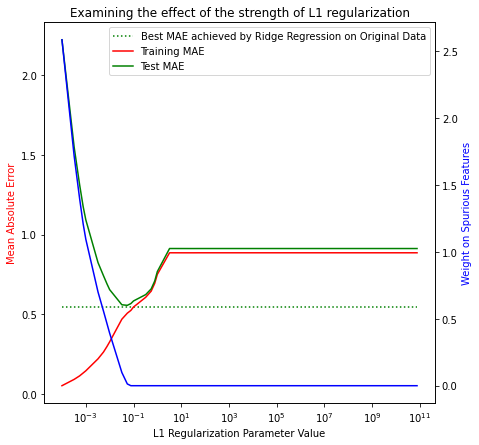

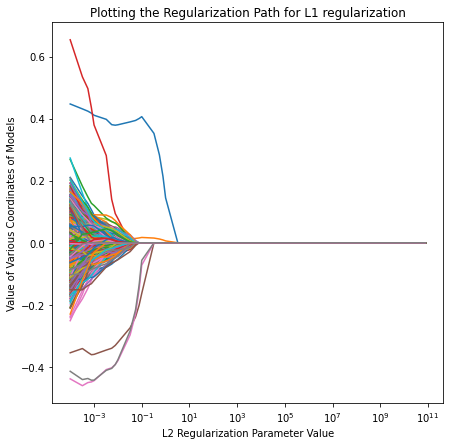

In [ ]:
fig5 = pd.getFigure( 7, 7 )
plt.plot( alphaVals, bestRRMAE * np.ones_like(alphaVals), color = 'g', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Original Data" )
plt.legend()
ax = plt.gca()
ax.set_title( "Examining the effect of the strength of L1 regularization" )
ax.set_xlabel( "L1 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals_trn, color = 'r', linestyle = '-', label = "Training MAE" )
ax.semilogx( alphaVals, MAEVals_tst, color = 'g', linestyle = '-', label = "Test MAE" )
ax.legend()
ax2 = ax.twinx()
ax2.set_ylabel( "Weight on Spurious Features", color = "b" )
ax2.semilogx( alphaVals, spuriousModelNorms, color = 'b', linestyle = '-' )

fig6 = pd.getFigure( 7, 7 )
plt.figure( fig6.number )
plt.title( "Plotting the Regularization Path for L1 regularization" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(X_trn_extend.shape[1]):
    plt.semilogx( alphaVals, models[i,:] )